## Moive Recommendation Using Spark
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.sql.functions import countDistinct, explode, split, concat_ws, collect_list, isnan

In [0]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
spark.conf.set("spark.executor.heartbeatInterval","3600s")

In [0]:


movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [0]:
display(movies)

In [0]:
display(ratings)

In [0]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [0]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 2: Spark SQL and OLAP

### The number of Users

In [0]:
num_users = ratings.select('userID').distinct().count()

print("the number of users is:", str(num_users))

the number of users is: 610

### The number of Movies

In [0]:
num_movies = movies.select('movieId').distinct().count()

print("the number of movies is:", num_movies)

the number of movies is: 9742

### How many movies are rated by users? List movies not rated before

In [0]:
# ratings_Id = ratings.select('movieId').distinct().withColumnRenamed('movieId','id')
# movie_rated = movies.filter(movies.movieId.isin(ratings_Id.id))
# print(movie_rated)
movie_not_rated = movies.join(ratings,movies.movieId == ratings.movieId,'leftanti')
print('{} out of {} movies are rated by users'.format(num_movies-movie_not_rated.count(),num_movies))


9724 out of 9742 movies are rated by users

In [0]:
display(movie_not_rated)

### List Movie Genres

In [0]:
movie_genre = movies.withColumn('genre', explode(split(movies.genres, '\|')))
genre = movie_genre.filter(movie_genre.genre != '(no genres listed)') \
                     .select(movie_genre.genre).distinct() \
                     .orderBy(movie_genre.genre)
display(genre)

### Movie for Each Category

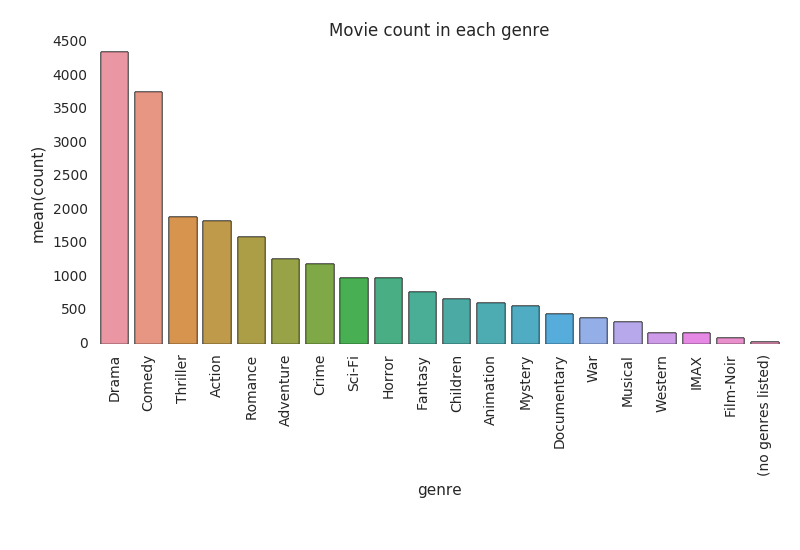

In [0]:
df_numGenre = movie_genre.groupBy(movie_genre.genre).count().orderBy('count', ascending = False)
df_numGenre = df_numGenre.toPandas()
ax = sns.barplot(x='genre', y='count',data = res)
ax.set_title('Movie count in each genre')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
display()

## Part3: Spark ALS based approach for training model



In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
#{"pyspark.mllib": "pyspark.rdd.RDD", "pyspark.ml": "pyspark.sql.DataFrame"}

In [0]:
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [0]:
header = movie_rating.take(1)[0]
print(header)
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()

userId,movieId,rating,timestamp

In [0]:
# check three rows
rating_data.take(3)


Out[ 5 ]: [(1, 1, 4.0), (1, 3, 4.0), (1, 6, 4.0)]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [0]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)
train = spark.createDataFrame(train)   #tranasform RDD to Dataframe 
validation = spark.createDataFrame(validation)   #tranasform RDD to Dataframe 
test = spark.createDataFrame(test)   #tranasform RDD to Dataframe 

In [0]:
train = train.selectExpr("_1 as userId", "_2 as movieId","_3 as rating")
train.cache()
display(train)

In [0]:
validation = validation.selectExpr("_1 as userId", "_2 as movieId","_3 as rating")
validation.cache()
display(validation)

In [0]:
test = test.selectExpr("_1 as userId", "_2 as movieId","_3 as rating")
test.cache()
display(test)

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [0]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    als = ALS(maxIter=num_iters, userCol='userId', itemCol='movieId', ratingCol='rating',coldStartStrategy="drop")
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
    for rank in ranks:
      for reg in reg_param:
            als.setParams(rank=rank,regParam=reg)
            model = als.fit(train_data)
            predictions = model.transform(validation_data)
            
            error = evaluator.evaluate(predictions)
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
              
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model 

In [0]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
best_model = train_ALS(train, validation, num_iterations, reg_params, ranks)


In [0]:
def plot_learning_curve(iter_array, train_data, validation_data, reg_param, rank):
  errors = []
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  for iterr in iter_array:
    # train the model by different iterations
    als = ALS(rank=rank, maxIter=iterr, regParam=reg_param, userCol="userId", itemCol="movieId", ratingCol="rating", \
              coldStartStrategy="drop")
    model = als.fit(train_data)
    # make prediction on validation data
    predictions = model.transform(validation_data)
    # calculate the rmse of the prediction
    error = evaluator.evaluate(predictions)
    errors.append(error)
  fig, ax = plt.subplots()
  ax.plot(iter_array, errors)
  ax.set_xlabel('iterations')
  ax.set_ylabel('RMSE')
  display(fig)
  return errors

In [0]:
iter_array = [1, 2, 5, 10]
plot_learning_curve(iter_array, train, validation, 0.2, 10)

### Model testing on the test data
And finally, make a prediction and check the testing error.

In [0]:

predictions = best_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8888862395630838